In [1]:
cd C:\Users\tania\Desktop\Minor project\Coding

C:\Users\tania\Desktop\Minor project\Coding


In [2]:
pwd

'C:\\Users\\tania\\Desktop\\Minor project\\Coding'

In [3]:
file_path = "./final_ipynb_1"

### Importing libraries

In [4]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation

%matplotlib inline

### Loading files

In [5]:
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_dict = pickle.load(open(file_path+'/saved_dict.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

In [6]:
# Making the train data sparse matrix
x_train_csr = csr_matrix(x_train.values)

col = x_train.columns

# Creating sparse dataframe with x_train sparse matrix
x_train = pd.DataFrame.sparse.from_spmatrix(x_train_csr, columns=col) 

In [7]:
# Saving it to disk to use later
pickle.dump((x_train, y_train), open(file_path+'/train_sparse.pkl', 'wb'))

# Loading sparse data
x_train, y_train = pickle.load(open(file_path+'/train_sparse.pkl', 'rb'))

In [8]:
x_train.sparse.to_dense().head()

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,synack,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,2.561444,-0.717760,-1.196045,-0.225343,-0.089113,-1.172764,-0.057567,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.037542,-0.717760,-1.196045,-0.225343,-0.089113,0.868469,-0.069616,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.157401,-0.069485,-0.054857,-0.121383,-0.107394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.136357,-0.063807,-0.044512,-0.120830,-0.107159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.144197,-0.069180,-0.054358,-0.123351,-0.110421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

### Pipeline functions

In [10]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"None" if x=="-" else x)

        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [11]:
def get_final_data(data, saved_dict=saved_dict, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']
    
    data['network_bytes'] = data['dbytes'] + data['sbytes']
    
    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)
    
    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)
    
    return data

In [22]:
x_test

,sttl,dttl,swin,trans_depth,res_bdy_len,stime,sintpkt,dintpkt,tcprtt,synack,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,-0.426051,-0.041365,-1.196045,-0.225343,-0.089113,-1.148407,-0.069615,-0.055095,-0.136439,-0.128893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.426051,-0.041365,-1.196045,-0.225343,-0.089113,-1.163715,-0.069617,-0.055093,-0.136439,-0.128893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.037542,-0.717760,-1.196045,-0.225343,-0.089113,0.855736,-0.069616,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,-1.157963,-0.069518,-0.054912,-0.121029,-0.107473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.426051,-0.041365,-1.196045,-0.225343,-0.089113,0.864749,-0.069616,-0.055095,-0.136439,-0.128893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762010,-0.037542,-0.717760,-1.196045,-0.225343,-0.089113,0.863408,-0.069618,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762011,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,0.868763,-0.063459,-0.024255,-0.121604,-0.107787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762012,-0.426051,-0.041365,0.836096,-0.225343,-0.089113,0.873861,-0.062135,-0.041193,-0.122577,-0.108731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
762013,2.561444,-0.717760,-1.196045,-0.225343,-0.089113,0.860948,-0.069617,-0.055099,-0.136439,-0.128893,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training and validation of models

In [12]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

ValueError: Length mismatch: Expected axis has 197 elements, new values have 48 elements

In [13]:
# Making test data sparse matrix
x_test_csr = csr_matrix(x_test.values)
col = x_test.columns

# Creating x_test sparse dataframe
x_test = pd.DataFrame.sparse.from_spmatrix(x_test_csr, columns=col)

In [14]:
x_train.shape, y_train.shape

((1778032, 197), (1778032,))

In [15]:
x_test.shape, y_test.shape

((762015, 197), (762015,))

In [16]:
all(x_train.columns == x_test.columns)

True

### Utility functions

In [17]:
def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [18]:
def hyperparam_tuning(clf, parameters, x, y, method='gridsearch', cv=None):
    """
    Utility function for Tuning hyperparameters
    """
    # initialization
    scoring = {'auc':'roc_auc',
               'f1':'f1',
               'FAR':make_scorer(false_alarm_rate, greater_is_better=False)}  # using custom scoring function FAR.
                
    # param tuning
    if method=='gridsearch':
        # As we are using multi scoring, So we need to point refit to scoring function with which we want to evaluate score
        tuning_clf = GridSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)
    
    elif method=='randomsearch':
        tuning_clf = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='auc',
                                        cv=cv, verbose=3, return_train_score=True)
        result = tuning_clf.fit(x, y)

    return result

In [19]:
def result_visualization(tuned_clf, parameters, param1=None, param2=None):
    """
    Utility function to plot the results obtained after hyper parameter tuning 
    """
    # getting train and test scores to plot
    train_score = tuned_clf.cv_results_['mean_train_auc']
    test_score = tuned_clf.cv_results_['mean_test_auc']

    # print results
    print("Best Score: {}".format(tuned_clf.best_score_))
    print("Best Parameters: {}".format(tuned_clf.best_params_))

    # Want to visualize score with 2 params, plot heatmap of the 3 variables
    if param2 is not None:
        # heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(train_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # test heapmap
        sns.heatmap(test_score.reshape(len(parameters[param1]), len(parameters[param2])),
                    cmap=test_cmap, annot=True, fmt='.6f', ax=test_ax,
                    xticklabels=parameters[param2], yticklabels=parameters[param1])
        
        # axis labels and plot title
        train_ax.set_title("Train hyperparam heatmap")
        train_ax.set_xlabel(param2)
        train_ax.set_ylabel(param1)

        test_ax.set_title("Test hyperparam heatmap")
        test_ax.set_xlabel(param2)
        test_ax.set_ylabel(param1)
        plt.show()
    
    # Want to visualize score with one param, simply plot score and param
    else:
        plt.figure(figsize=(10,5))
        plt.plot(np.log10(parameters[param1]), train_score, label="train")
        plt.plot(np.log10(parameters[param1]), test_score, label="test")

        # Plot for train data
        for i, txt in enumerate(train_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], train_score[i]))
        
        # Plot for test data
        for i, txt in enumerate(test_score):
            plt.annotate((parameters[param1][i], np.round(txt, 3)), (np.log10(parameters[param1])[i], test_score[i]))
        
        plt.xlabel(param1)
        plt.ylabel('performance')
        plt.grid()
        plt.legend()
        plt.show()

In [20]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    return clf, test_auc, test_f1, test_far

### Logistic Regression


We are starting with basic Logistic Regression for training our data.

Going tune hyperparameter "alpha" and "penalty"

In [21]:
# Tuning "alpha" for l2 "penalty"
clf = SGDClassifier(loss='log', penalty='l2')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END alpha=1e-06; FAR: (train=-0.013, test=-0.014) auc: (train=0.999, test=0.999) f1: (train=0.957, test=0.956) total time=  39.5s
[CV 2/3] END alpha=1e-06; FAR: (train=-0.014, test=-0.014) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.959) total time=  29.6s
[CV 3/3] END alpha=1e-06; FAR: (train=-0.026, test=-0.026) auc: (train=0.999, test=0.999) f1: (train=0.957, test=0.957) total time=  32.8s
[CV 1/3] END alpha=1e-05; FAR: (train=-0.027, test=-0.027) auc: (train=0.999, test=0.999) f1: (train=0.956, test=0.955) total time=  13.6s
[CV 2/3] END alpha=1e-05; FAR: (train=-0.017, test=-0.017) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.958) total time=  14.9s
[CV 3/3] END alpha=1e-05; FAR: (train=-0.021, test=-0.020) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.960) total time=  13.8s
[CV 1/3] END alpha=0.0001; FAR: (train=-0.023, test=-0.022) auc: (train=0.999, test=0.999) f1: (train=0.95

Best Score: 0.9991999054618019
Best Parameters: {'alpha': 1e-05}


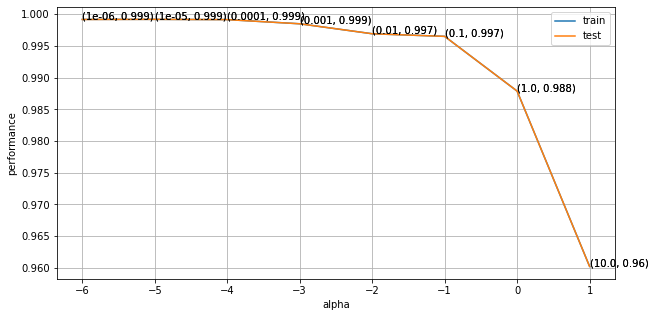

In [23]:
# Plotting the result to select best parameter
result_visualization(lr_clf, param, param1='alpha')

In [24]:
# Tuning "alpha" for l1 "penalty"
clf = SGDClassifier(loss='log', penalty='l1')
param = {'alpha':np.logspace(-6, 1, 8)}  # Values of alpha

lr_clf = hyperparam_tuning(clf, param, x_train_csr, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END alpha=1e-06; FAR: (train=-0.025, test=-0.026) auc: (train=0.999, test=0.999) f1: (train=0.956, test=0.954) total time=  55.9s
[CV 2/5] END alpha=1e-06; FAR: (train=-0.034, test=-0.036) auc: (train=0.999, test=0.999) f1: (train=0.951, test=0.949) total time= 1.1min
[CV 3/5] END alpha=1e-06; FAR: (train=-0.014, test=-0.014) auc: (train=0.999, test=0.999) f1: (train=0.957, test=0.958) total time=  51.1s
[CV 4/5] END alpha=1e-06; FAR: (train=-0.021, test=-0.022) auc: (train=0.999, test=0.999) f1: (train=0.956, test=0.956) total time=  49.5s
[CV 5/5] END alpha=1e-06; FAR: (train=-0.040, test=-0.039) auc: (train=0.999, test=0.999) f1: (train=0.950, test=0.951) total time=  39.4s
[CV 1/5] END alpha=1e-05; FAR: (train=-0.021, test=-0.021) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.958) total time=  23.2s
[CV 2/5] END alpha=1e-05; FAR: (train=-0.026, test=-0.027) auc: (train=0.999, test=0.999) f1: (train=0.957

Best Score: 0.9991722915959278
Best Parameters: {'alpha': 1e-06}


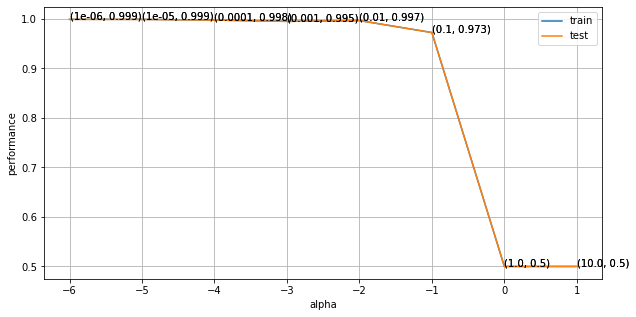

In [25]:
# Plotting alpha vs score
result_visualization(lr_clf, param, 'alpha')

In [26]:
# Best LR model
lr_bst_clf = SGDClassifier(penalty='l1', alpha=1e-6)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   LR  | 0.9709182069807337 | 0.9559773810644889 | 0.029081793019266212 |
|   Test  |   LR  | 0.9700835579628607 | 0.954977685963446  | 0.029916442037139227 |
+---------+-------+--------------------+--------------------+----------------------+


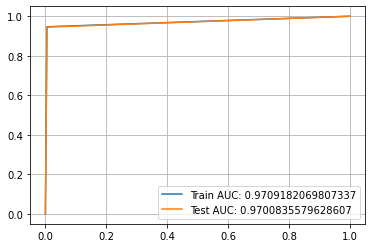

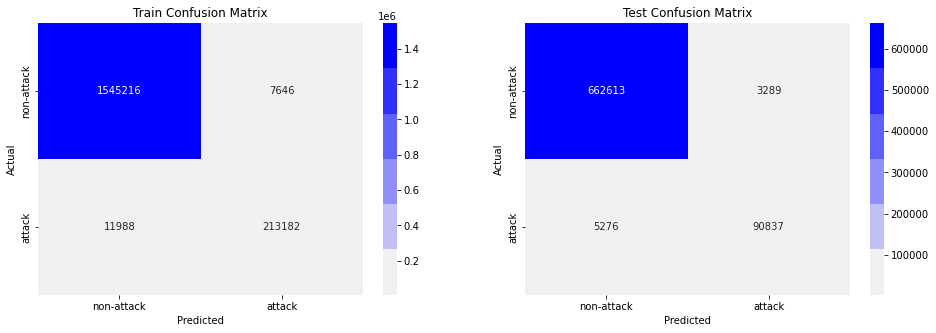

In [27]:
# Getting best model's performance on train and test data
lr_clf, lr_auc, lr_f1, lr_far = evaluate_result(lr_bst_clf, x_train, y_train, x_test, y_test, 'LR')

ValueError: Found input variables with inconsistent numbers of samples: [1422425, 762015]

Observation

1.Using wide range of values for "alpha" from 10^-6 to 10^3 and "penalty" l1 and l2

2.Can observe that upto alpha=0.1 model's score is good and then its falling down heavily.

3.The best parameter of the model for our data is "penalty" l1 and "alpha" 10^-6

4.Both train and test auc score are very close that means model is not overfitting.

5.Model is performing well but there are few False Positive points in the result

In [28]:
# An empty dictionary to store the result of all the models
result_dict = {"name":[], "auc":[], "f1":[], "far":[]}

In [29]:
# Storinig result for LR
result_dict['name'].append("LR")
result_dict['auc'].append(lr_auc)
result_dict['f1'].append(lr_f1)
result_dict['far'].append(lr_far)

In [30]:
pickle.dump(lr_clf, open(file_path+'/lr_clf.pkl', 'wb'))

In [32]:
result_dict

{'name': ['LR'],
 'auc': [0.9700835579628607],
 'f1': [0.954977685963446],
 'far': [0.029916442037139227]}

### Linear SVC

The next model we are going to try is Linear Support Vector Classifier

Tune parameters for "alpha" and "penalty"

In [33]:
# Tuning "alpha" and "penalty"
clf = SGDClassifier(loss='hinge')
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']}  # l1 an d l2 penalty

svm_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=1e-05, penalty=l1; FAR: (train=-0.033, test=-0.034) auc: (train=0.999, test=0.999) f1: (train=0.954, test=0.953) total time=  12.0s
[CV 2/3] END alpha=1e-05, penalty=l1; FAR: (train=-0.021, test=-0.022) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.958) total time=  10.3s
[CV 3/3] END alpha=1e-05, penalty=l1; FAR: (train=-0.016, test=-0.015) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.959) total time=   9.5s
[CV 1/3] END alpha=1e-05, penalty=l2; FAR: (train=-0.015, test=-0.016) auc: (train=0.999, test=0.999) f1: (train=0.960, test=0.958) total time=   7.4s
[CV 2/3] END alpha=1e-05, penalty=l2; FAR: (train=-0.013, test=-0.013) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.957) total time=   7.1s
[CV 3/3] END alpha=1e-05, penalty=l2; FAR: (train=-0.017, test=-0.017) auc: (train=0.999, test=0.999) f1: (train=0.958, test=0.959) total time=   7.6s
[CV 1/3] END alpha=0.0001, penalt

Best Score: 0.9989689248140006
Best Parameters: {'alpha': 1e-05, 'penalty': 'l1'}


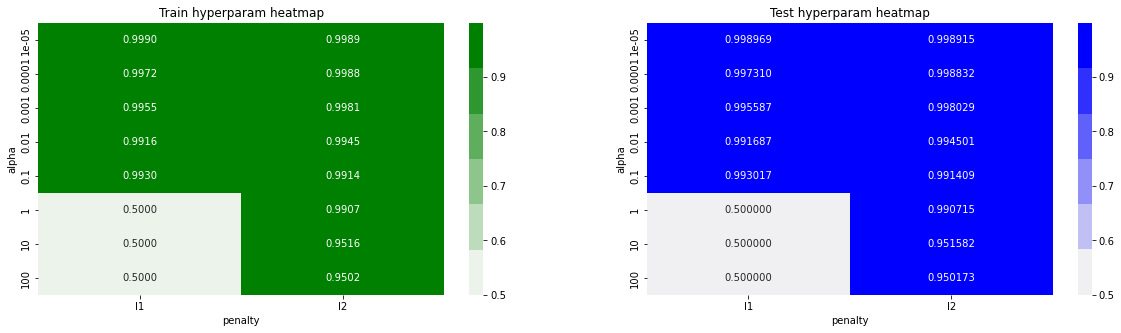

In [34]:
# Visualising scores, using heatmap to check the performance on "alpha" and "penalty"
result_visualization(svm_clf, param, 'alpha', 'penalty')

In [35]:
# Best svc model
best_svm_clf = svm_clf.best_estimator_

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |  SVM  | 0.9900916711535771 | 0.9554460630804912 | 0.00990832884642293  |
|   Test  |  SVM  | 0.9900365295638255 | 0.9553376469881208 | 0.009963470436174448 |
+---------+-------+--------------------+--------------------+----------------------+


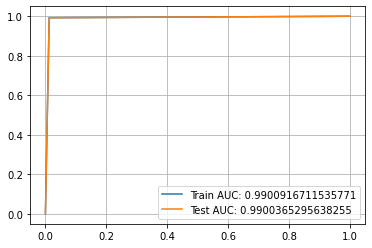

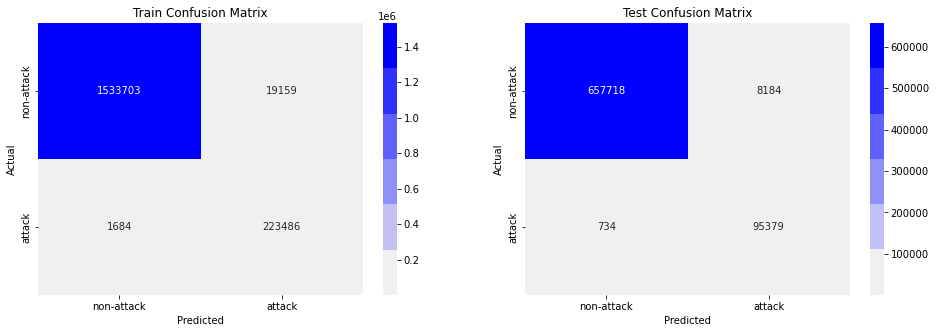

In [36]:
# Model performance on train and test
svm_clf, svm_auc, svm_f1, svm_far = evaluate_result(clf, x_train_csr, y_train, x_test_csr, y_test, "SVM")

Observation

1.Using wide range of "alpha" values from 10^-5 to 10^2 and l1, l2 "penalty"

2.For penalty=l1 model is behaving like a random model with auc=0.5 from alpha=1 to 100.

3.Best set of parameters for the model is alpha=10^-4 and penalty=l2

4.Train and Test score is very close so no overfitting here, getting better value of auc and FAR tha Logistic Regression

5.FAR value of this model is really good. The no of FP increased than LR but there are very few FN points in the result.

In [37]:
# Saving result of SVM
result_dict['name'].append("SVM")
result_dict['auc'].append(svm_auc)
result_dict['f1'].append(svm_f1)
result_dict['far'].append(svm_far)

In [38]:
pickle.dump(svm_clf, open(file_path+'/svm_clf.pkl', 'wb'))

In [39]:
pickle.dump(result_dict, open('result_dict.pkl', 'wb'))

### Decision Tree

Trying out DT for the next model.

Tune parameters for "max_depth", "min_samples_split" and "min_samples_leaf"

In [40]:
# DT classifier
clf = DecisionTreeClassifier()
param = {'max_depth':[8, 10, 12, 14],
         'min_samples_split':[2, 4, 6]}

dt_clf = hyperparam_tuning(clf, param, x_train_csr, y_train, cv=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_depth=8, min_samples_split=2; FAR: (train=-0.012, test=-0.012) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.959) total time=  13.7s
[CV 2/3] END max_depth=8, min_samples_split=2; FAR: (train=-0.014, test=-0.015) auc: (train=0.999, test=0.999) f1: (train=0.962, test=0.962) total time=  14.4s
[CV 3/3] END max_depth=8, min_samples_split=2; FAR: (train=-0.012, test=-0.012) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.959) total time=  14.2s
[CV 1/3] END max_depth=8, min_samples_split=4; FAR: (train=-0.012, test=-0.012) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.959) total time=  14.1s
[CV 2/3] END max_depth=8, min_samples_split=4; FAR: (train=-0.014, test=-0.015) auc: (train=0.999, test=0.999) f1: (train=0.962, test=0.962) total time=  14.0s
[CV 3/3] END max_depth=8, min_samples_split=4; FAR: (train=-0.012, test=-0.012) auc: (train=0.999, test=0.999) f1: (train=0.959, test=0.959

Best Score: 0.9993911679870581
Best Parameters: {'max_depth': 10, 'min_samples_split': 4}


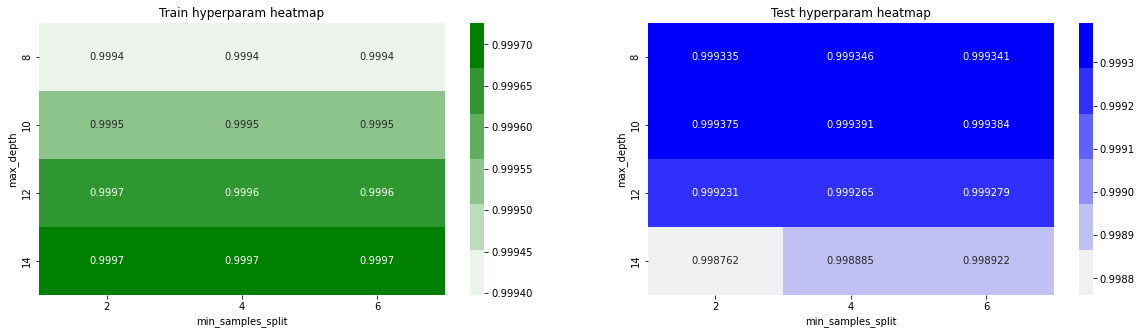

In [41]:
# Plotting heatmap of scores with params
result_visualization(dt_clf, param, 'max_depth', 'min_samples_split')

In [42]:
dt_clf.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=4)

In [43]:
# Tuning "min_samples_leaf" on top of best found params
clf = dt_clf.best_estimator_
param = {'min_samples_leaf':[9, 11, 13]}

dt_clf = hyperparam_tuning(clf, param, x_train_csr, y_train,cv=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END min_samples_leaf=9; FAR: (train=-0.012, test=-0.012) auc: (train=1.000, test=0.999) f1: (train=0.964, test=0.963) total time=  14.5s
[CV 2/3] END min_samples_leaf=9; FAR: (train=-0.029, test=-0.031) auc: (train=1.000, test=0.999) f1: (train=0.963, test=0.961) total time=  16.4s
[CV 3/3] END min_samples_leaf=9; FAR: (train=-0.013, test=-0.013) auc: (train=1.000, test=0.999) f1: (train=0.964, test=0.963) total time=  16.1s
[CV 1/3] END min_samples_leaf=11; FAR: (train=-0.012, test=-0.012) auc: (train=1.000, test=0.999) f1: (train=0.963, test=0.963) total time=  15.8s
[CV 2/3] END min_samples_leaf=11; FAR: (train=-0.029, test=-0.031) auc: (train=1.000, test=0.999) f1: (train=0.963, test=0.961) total time=  16.5s
[CV 3/3] END min_samples_leaf=11; FAR: (train=-0.013, test=-0.013) auc: (train=1.000, test=0.999) f1: (train=0.964, test=0.963) total time=  16.1s
[CV 1/3] END min_samples_leaf=13; FAR: (train=-0.012, test=-0.

Best Score: 0.9994585178953828
Best Parameters: {'min_samples_leaf': 11}


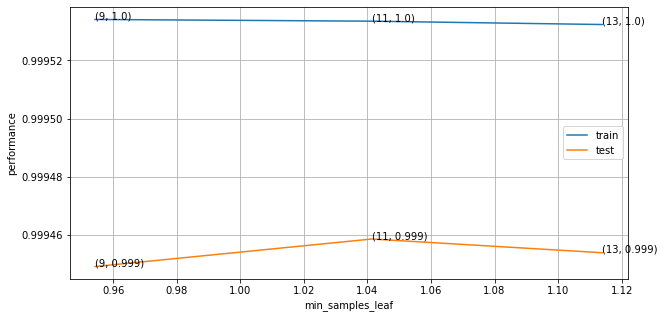

In [44]:
result_visualization(dt_clf, param, 'min_samples_leaf')

Best value of "min_samples_leaf" is 11

In [45]:
dt_param = {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf':9}

dt_best_clf = DecisionTreeClassifier(**dt_param)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   DT  | 0.9879649532321753 | 0.9634806494164075 | 0.012035046767824754 |
|   Test  |   DT  | 0.9877274028109072 | 0.9628257328990228 | 0.012272597189092835 |
+---------+-------+--------------------+--------------------+----------------------+


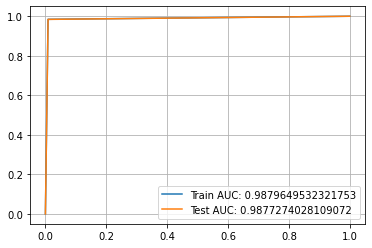

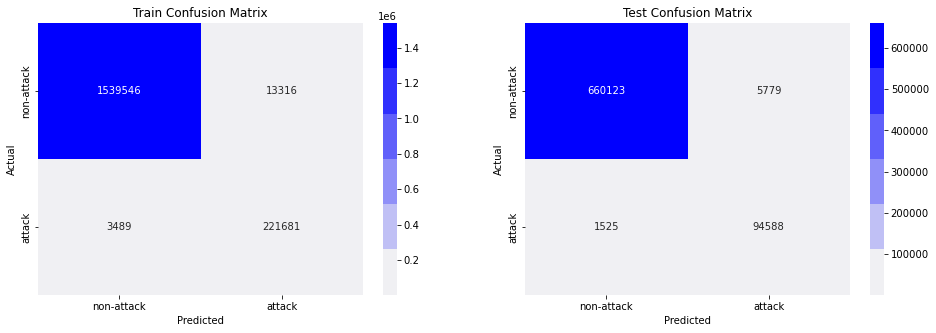

In [46]:
dt_clf, dt_auc, dt_f1, dt_far = evaluate_result(dt_best_clf, x_train_csr, y_train, x_test_csr, y_test, 'DT')

In [47]:
# Saving the Model to disk
pickle.dump(dt_clf, open(file_path+'/dt_clf.pkl', 'wb'))

In [48]:
result_dict = pickle.load(open('./result_dict.pkl', 'rb'))

In [49]:
# Saving scores of DT
result_dict['name'].append("DT")
result_dict['auc'].append(dt_auc)
result_dict['f1'].append(dt_f1)
result_dict['far'].append(dt_far)

In [50]:
result_dict

{'name': ['LR', 'SVM', 'DT'],
 'auc': [0.9700835579628607, 0.9900365295638255, 0.9877274028109072],
 'f1': [0.954977685963446, 0.9553376469881208, 0.9628257328990228],
 'far': [0.029916442037139227, 0.009963470436174448, 0.012272597189092835]}

Observation

1.Tuning parameters for "max_depth", "min_sampples_split" and "min_samples_leaf".

2.Performance is mostly dependent on "max_depth" and less dependent on other 2 params.

3.Best parameters for the model max_depth=10, min_samples_split=6 and min_samples_leaf=9

4.Train and Test score is very close so no overfitting here, getting better value of F1 score with this model than the other 2 above.

5.NO of False Positive reduced for this model.

### Cross Validation function

For Random Forest and XGBClassifier, we will tuning its hyperparameters with train and cv data and using loops. Because the dataset is very large and with grid or randomsearch it will take so much time.

In [51]:
# Splitting train in train and cv data
x_train_new_csr, x_cv_csr, y_train, y_cv = train_test_split(x_train_csr, y_train, test_size=0.2, random_state=42)

In [52]:
x_train_new_csr.shape, y_train.shape, x_cv_csr.shape, y_cv.shape, x_test_csr.shape, y_test.shape

((1422425, 197),
 (1422425,),
 (355607, 197),
 (355607,),
 (762015, 197),
 (762015,))

In [53]:
def cross_validation(clf_name, param, param_tune,
                     x_train=x_train_new_csr, y_train=y_train, x_cv=x_cv_csr, y_cv=y_cv):
    """
    Using this function to cross validate with train and cv data.
    Parameters:
        clf_name = Name of the classifier
        param = Dictionary of hyperparameters and params for classifier
        param_tune = Name of the parameter to tune
        x_train, y_train = Train data and Train label
        x_cv, y_cv = CV data and CV label
    """
    # Initializing empty list to store train and cv scores
    train_auc_list = []
    cv_auc_list = []
    
    # Assigning arguments to variables
    hyper_param = param_tune
    values = param.pop(hyper_param)
    classifier = clf_name

    # Looping through the list of hyper parameter
    for i in tqdm(values):
        clf = classifier(**{hyper_param:i}, **param, n_jobs=-1)
        clf.fit(x_train, y_train)  # Training

        # Predicting probability of targets
        y_train_pred = clf.predict_proba(x_train)[:,1]
        y_cv_pred = clf.predict_proba(x_cv)[:,1]

        # Getting scores
        train_auc_list.append(roc_auc_score(y_train, y_train_pred))
        cv_auc_list.append(roc_auc_score(y_cv, y_cv_pred))

        print("For {}: {}, train auc: {} and test auc {}".format(hyper_param, i, train_auc_list[-1], cv_auc_list[-1]))
    
    # Plotting scores
    plt.figure(figsize=(10,5))
    plt.plot(values, train_auc_list, label="train")
    plt.plot(values, cv_auc_list, label="cv")

    for i, txt in enumerate(train_auc_list):
        plt.annotate((values[i], np.round(txt, 3)), (values[i], train_auc_list[i]))
    for i, txt in enumerate(cv_auc_list):
        plt.annotate((values[i], np.round(txt, 3)), (values[i], cv_auc_list[i]))
    
    plt.xlabel(hyper_param)
    plt.ylabel('auc score')
    plt.grid()
    plt.legend()
    plt.show()

    # Finding best parameter with highest cv score
    best_param = np.argmax(cv_auc_list)
    clf = classifier(**{hyper_param:values[best_param]}, **param)  # Trained model

    return clf, hyper_param, values[best_param]

### Random Forest

Trying Random Forest Classifier next.
Tuning 'n_estimators', 'max_depth', 'min_samples_split' and 'criterion'

In [54]:
# Classifier Name
CLF_NAME = RandomForestClassifier

 25%|██▌       | 1/4 [08:13<24:39, 493.13s/it]

For n_estimators: 100, train auc: 0.9999999124257893 and test auc 0.999753814140287


 50%|█████     | 2/4 [26:43<28:32, 856.46s/it]

For n_estimators: 200, train auc: 0.9999999369535394 and test auc 0.9997690534174659


 75%|███████▌  | 3/4 [50:16<18:30, 1110.50s/it]

For n_estimators: 300, train auc: 0.9999999431111708 and test auc 0.9997614429138263


100%|██████████| 4/4 [1:20:12<00:00, 1203.03s/it]

For n_estimators: 400, train auc: 0.9999999323956408 and test auc 0.9997819342329535


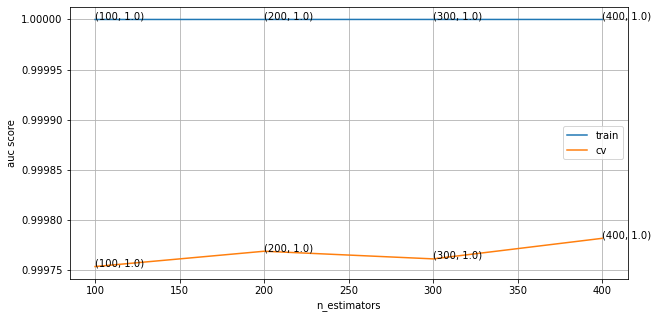

In [56]:
# Tuning No of estimators
param = {'n_estimators':[100, 200, 300, 400]}
rf_clf, param1, val1 = cross_validation(CLF_NAME, param, 'n_estimators')

 33%|███▎      | 1/3 [03:55<07:50, 235.20s/it]

For max_depth: 20, train auc: 0.9999333029217792 and test auc 0.9997722511861872


 67%|██████▋   | 2/3 [08:19<04:12, 252.44s/it]

For max_depth: 22, train auc: 0.9999624357980091 and test auc 0.9997807247727531


100%|██████████| 3/3 [13:35<00:00, 271.99s/it]

For max_depth: 24, train auc: 0.9999848407423917 and test auc 0.999785365434501


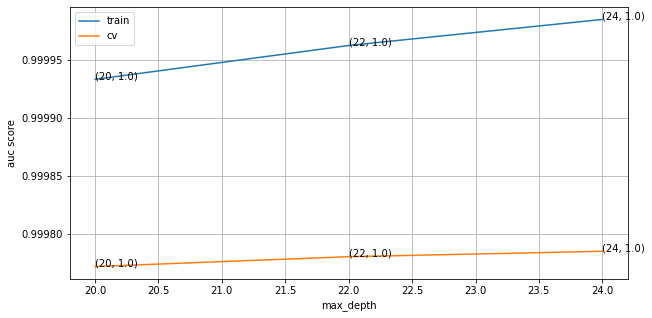

In [57]:
# Tuning Max depth
param = {'max_depth':[20, 22, 24]}
dt_clf, param2, val2 = cross_validation(CLF_NAME, param, 'max_depth')

 33%|███▎      | 1/3 [04:24<08:48, 264.11s/it]

For min_samples_split: 2, train auc: 0.9999646013226137 and test auc 0.9997788889159969


 67%|██████▋   | 2/3 [07:59<03:55, 235.56s/it]

For min_samples_split: 4, train auc: 0.9999513037274756 and test auc 0.9997668924923595


100%|██████████| 3/3 [11:13<00:00, 224.60s/it]

For min_samples_split: 6, train auc: 0.9999406943250152 and test auc 0.9997759075615654


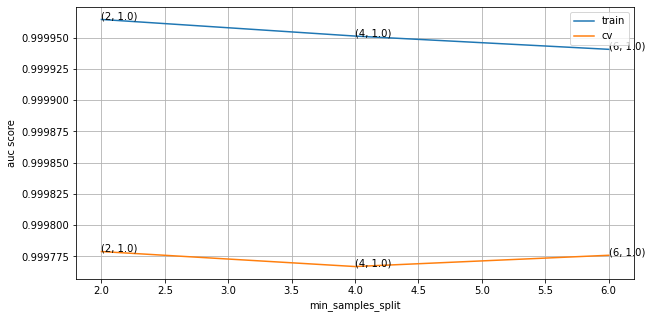

In [58]:
# Tuning Min samples split
param = {'min_samples_split':[2, 4, 6], 'max_depth':22}
dt_clf = cross_validation(CLF_NAME, param, 'min_samples_split')

 50%|█████     | 1/2 [03:14<03:14, 194.48s/it]

For criterion: gini, train auc: 0.9999411247515004 and test auc 0.9997780723480203


100%|██████████| 2/2 [06:24<00:00, 192.00s/it]

For criterion: entropy, train auc: 0.9999216463756526 and test auc 0.9997590740121919


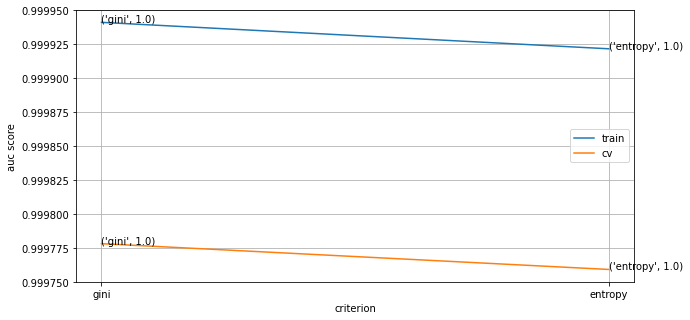

In [59]:
# Tuning Criterion
param = {'criterion':['gini', 'entropy'], 'min_samples_split':6, 'max_depth':22}
dt_clf, _, _ = cross_validation(CLF_NAME, param, 'criterion')

In [60]:
# Best RandomForest model
rf_bst_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)

+---------+-------+--------------------+--------------------+----------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+-------+--------------------+--------------------+----------------------+
|  Train  |   RF  | 0.9927781255062542 | 0.9898325475441885 | 0.007221874493745863 |
|   Test  |   RF  | 0.9856855036374929 | 0.9768781001757746 | 0.01431449636250722  |
+---------+-------+--------------------+--------------------+----------------------+


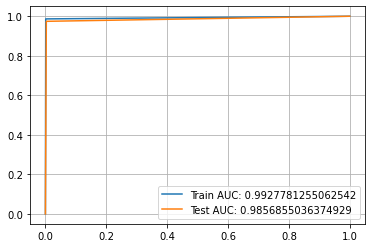

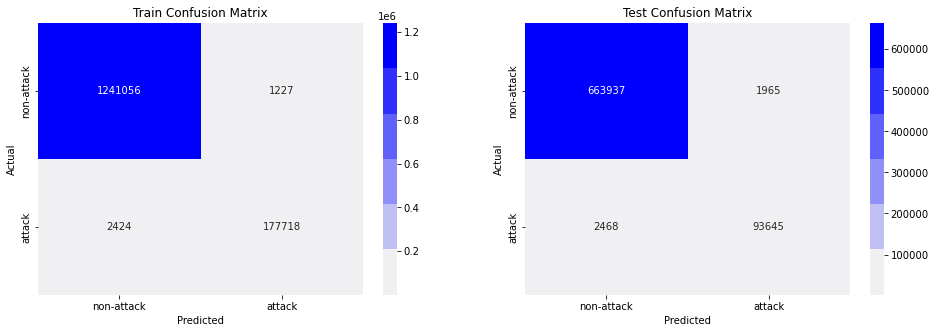

(RandomForestClassifier(max_depth=22, min_samples_split=6, n_estimators=300,
                        n_jobs=-1),
 0.9856855036374929,
 0.9768781001757746,
 0.01431449636250722)

In [61]:
# Getting result on train and test data
evaluate_result(rf_bst_clf, x_train_new_csr, y_train, x_test_csr, y_test, "RF")

Observation

1.Tuning lots of parameters for this classifier with appropriate values.

2.Performance is mostly dependent on "n_estimators", "max_depth" and less dependent on other 2 params.

3.Best parameters for the model: criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300

4.Train and Test score is close but compared to above models there is a gap between train and test score. So it is overfitting on train data if wwe compare with above models. But the gap is very low so not much of overfitting.

5.No of False Positive reduced heavily, but No of False Negetive incresed.

In [62]:
pickle.dump(rf_bst_clf, open(file_path+'/rf_best_clf.pkl', 'wb'))

In [63]:
result_dict = pickle.load(open('result_dict.pkl', 'rb'))

In [64]:
# Adding results
result_dict['name'].append("RF")
result_dict['auc'].append(0.9854768258366028)
result_dict['f1'].append(0.9767504956694146)
result_dict['far'].append(0.01452317416339732)

In [65]:
pd.DataFrame(result_dict)

,name,auc,f1,far
0,LR,0.970084,0.954978,0.029916
1,SVM,0.990037,0.955338,0.009963
2,RF,0.985477,0.976750,0.014523


In [66]:
pickle.dump(result_dict, open(file_path+'/final_result_dict.pkl', 'wb'))

### GBDT

Trying out Gradient boosted decision tree.

For this model there are lots of hyperparameters to tune like, 'learning_rate', 'max_depth', 'colsample_bylevel', 'subsample' and 'n_estimators'

In [67]:
CLF_NAME = xgb.XGBClassifier

  0%|          | 0/3 [00:00<?, ?it/s]

[09:42:35] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 1/3 [03:30<07:01, 210.99s/it]

For learning_rate: 0.001, train auc: 0.999196386497395 and test auc 0.9991733900857613
[09:46:06] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 2/3 [06:58<03:28, 208.71s/it]

For learning_rate: 0.01, train auc: 0.9995339574367829 and test auc 0.999528613351781
[09:49:33] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 3/3 [10:12<00:00, 204.06s/it]

For learning_rate: 0.1, train auc: 0.9997381623647525 and test auc 0.9997165027865066


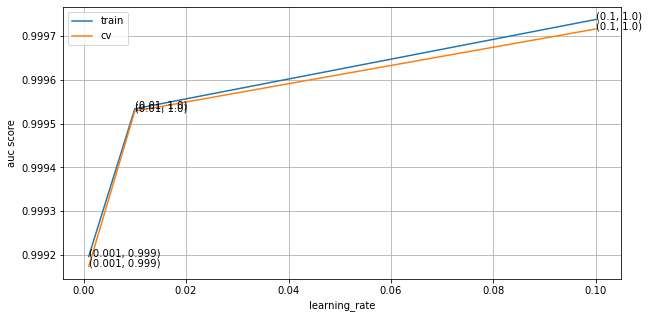

In [68]:
param = {'learning_rate':[0.001, 0.01, 0.1]}
xgb_clf = cross_validation(CLF_NAME, param, 'learning_rate')

  0%|          | 0/3 [00:00<?, ?it/s]

[09:54:46] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 33%|███▎      | 1/3 [02:33<05:07, 153.72s/it]

For max_depth: 4, train auc: 0.9997990742252939 and test auc 0.9997674790955731
[09:57:20] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 67%|██████▋   | 2/3 [07:18<03:50, 230.88s/it]

For max_depth: 8, train auc: 0.9999572278493459 and test auc 0.9998679420554571
[10:02:07] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 3/3 [23:16<00:00, 465.49s/it]

For max_depth: 12, train auc: 0.9999965891502811 and test auc 0.9998948996676652


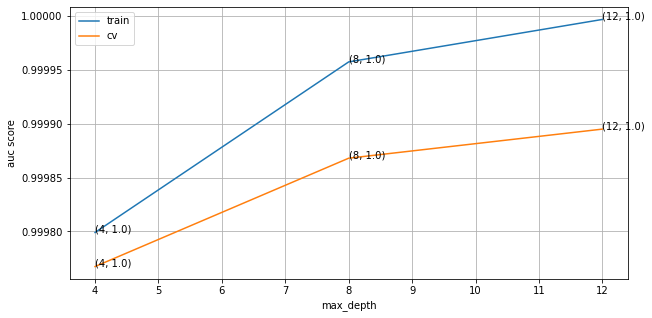

In [69]:
param = {'max_depth':[4, 8, 12]}

xgb_clf, _, _ = cross_validation(CLF_NAME, param, 'max_depth')

In [70]:
train_sample = np.random.randint(0, x_train.shape[0], size=700000)

In [105]:
param = {'colsample_bylevel':[0.1, 0.5, 1]}
xgb_clf,_,_ = cross_validation(CLF_NAME, param, 'colsample_bylevel', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

IndexError: positional indexers are out-of-bounds

In [72]:
param = {'subsample':[0.1, 0.4, 0.7, 1]}
xgb_xlf,_,_ = cross_validation(CLF_NAME, param, 'subsample', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

IndexError: positional indexers are out-of-bounds

In [89]:
param = {'n_estimators':[400]}
xgb_clf,_,_ = cross_validation(CLF_NAME, param, 'n_estimators', x_train=x_train.iloc[train_sample], y_train=y_train.iloc[train_sample])

IndexError: positional indexers are out-of-bounds

In [74]:
best_params = {'n_estimators':400,
               'max_depth':12,
               'learning_rate':0.1,
               'colsample_bylevel':0.5,
               'subsample':0.1,
               'n_jobs':-1}

xgb_bst_clf = xgb.XGBClassifier(**best_params)
xgb_clf, xgb_auc, xgb_f1, xgb_far = evaluate_result(xgb_bst_clf, x_train_new_csr, y_train, x_test_csr, y_test, 'XGB')

[10:20:19] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [78]:
pickle.dump(xgb_clf, open(file_path+'/xgb_clf.pkl', 'wb'))

In [79]:
result_dict = pickle.load(open(file_path+'/final_result_dict.pkl', 'rb'))

In [80]:
pd.DataFrame(result_dict)[['name', 'auc', 'f1', 'far']]

,name,auc,f1,far
0,LR,0.970084,0.954978,0.029916
1,SVM,0.990037,0.955338,0.009963
2,RF,0.985477,0.976750,0.014523


Observation

1.Tuning lots of parameters for this classifier with appropriate values.

2.Performance is mostly dependent on "learning_rate" somewhat on "max_depth" and "n_estimators" and less dependent on other 2 params.

3.Best parameters for the model- 'n_estimators':400, 'max_depth':12, 'learning_rate':0.1, 'colsample_bylevel':0.5, 'subsample':0.1, 'n_jobs':-1

4.Train and Test score is close but compared to above models there is a gap between train and test score. So it is overfitting on train data if wwe compare with above models. But the gap is very low so not much of overfitting.

5.In train data FAR is very very low, but in test there is still almost equal FN and FP

In [81]:
pickle.dump(result_dict, open('result_dict.pkl', 'wb'))

In [82]:
XGB_clf = pickle.load(open(file_path+'/xgb_clf.pkl', 'rb'))

### Getting Important features

In [83]:
# Totol features with some importance
np.count_nonzero(XGB_clf.feature_importances_)

NotFittedError: need to call fit or load_model beforehand

In [97]:
# Getting the indices of the features sorted in descending order
indices = np.argsort(-1 * abs(xgb_clf.feature_importances_))[:55]

NotFittedError: need to call fit or load_model beforehand

In [ ]:
# Saving for later use
saved_dict['imp_indices'] = indices

In [ ]:
pickle.dump(saved_dict, open(file_path+'/saved_dict.pkl', 'wb'))

In [ ]:
x_train_new_csr[:,indices].shape

### Plotting Features and their Importance

In [98]:
plt.figure(figsize=(20,8))
plt.bar(x_train.columns[indices], abs(xgb_clf.feature_importances_[indices]))
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Plot of features and its importance")
plt.grid()
plt.show()

NameError: name 'indices' is not defined

<Figure size 1440x576 with 0 Axes>

### Models on Important features

Again Training few models from above and then compare the result of model with all parameters and only important parameters.

In [99]:
dt_clf_imp = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
dt_clf_imp, dt_fi_auc, dt_fi_f1, dt_fi_far = evaluate_result(dt_clf_imp, x_train_new_csr[:,indices], y_train, x_test_csr[:,indices], y_test, 'DT_FI')

NameError: name 'indices' is not defined

In [100]:
#result_dict = pickle.load(open('result_dict.pkl', 'rb'))

result_dict['name'].append('DT_FI')
result_dict['auc'].append(dt_fi_auc)
result_dict['f1'].append(dt_fi_f1)
result_dict['far'].append(dt_fi_far)

NameError: name 'dt_fi_auc' is not defined

In [ ]:
pd.DataFrame(result_dict)

Observations

1.Retraining the best Decision Tree model with data containing only important features.

2.From observing the result we can see that there is not much difference in scores, but yes they have reduced very little.

In [ ]:
pickle.dump(dt_clf_imp, open(file_path+'/dt_clf_imp.pkl', 'wb'))

### RF with Imp Params

In [ ]:
rf_clf_imp = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
rf_clf_imp, rf_fi_auc, rf_fi_f1, rf_fi_far = evaluate_result(rf_clf_imp, x_train_new_csr[:,indices], y_train, x_test_csr[:,indices], y_test, 'RF_FI')

In [ ]:
pickle.dump(rf_clf_imp, open(file_path+'/rf_clf_imp.pkl', 'wb'))

In [ ]:
for i,j in zip(result_dict.keys(), ["RF_FI", rf_fi_auc, rf_fi_f1, rf_fi_far]):
    result_dict[i].append(j)

In [ ]:
pd.DataFrame(result_dict)

Observations

1.Training the best Random Forest model again with only important features

2.We can see that the performance has increased

3.This model is giving the highest scores amongst all the models we have trained till now

In [ ]:
# Re-creating data with imp feat

x_train = x_train_new_csr[:, indices]
x_cv = x_cv_csr[:, indices]
x_test = x_test_csr[:, indices]

In [ ]:
x_train.shape, x_cv.shape, x_test.shape

### Ensembles

#### Voting Classifier Model

Trining a ensemble model using voting classifier, Taking 3 classifiers DecisionTree, RandomForest and XGBClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
# Initializing all the 3 classifiers with best found parameters
dt_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=6, min_samples_leaf=9)
rf_clf = RandomForestClassifier(criterion='gini', max_depth=22, min_samples_split=6, n_estimators=300, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.1, colsample_bylevel=0.5, subsample=0.1, n_jobs=-1)

In [ ]:
# Result with voting classifier
v_clf = VotingClassifier(estimators=[('dt', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)
v_clf, v_auc, v_f1, v_far = evaluate_result(v_clf, x_train, y_train, x_test, y_test, "Voting Clf")

In [ ]:
pickle.dump(v_clf, open(file_path+'/v_clf.pkl', 'wb'))

In [ ]:
for i,j in zip(result_dict.keys(), ["Voting", v_auc, v_f1, v_far]):
    result_dict[i].append(j)

In [ ]:
pd.DataFrame(result_dict)

Observations

1.Training this model using 3 model best Dt, best RF and best XGB.

2.The auc score of this model is higher than any other model.

3.There is a gap in train and test auc and higher gap in train and test f1 and FAR

4.In train the FAR is very very low but in test there are still few FP and FN and they are almost equal in number

In [ ]:
pickle.dump(result_dict, open(file_path+'/final_result_dict.pkl', 'wb'))

In [ ]:
best_model = pickle.load(open(file_path+'/rf_clf_imp.pkl', 'rb'))

In [ ]:
f1_score(y_test, best_model.predict(x_test_csr[:, indices]))